In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install konlpy

In [3]:
!cp '/content/drive/MyDrive/Colab Notebooks/NLP/preprocess.py' .

In [4]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [5]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

In [6]:
DATA_IN_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/data_in/'
DATA_OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/models'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'

In [7]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [8]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [9]:
MODEL_NAME = 'transformer_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCH = 30
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']

sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']


kargs = {'model_name': MODEL_NAME, 
         'num_layers': 2, 
         'd_model': 512, 
         'num_heads':8,
         'dff':2048, 
         'input_vocab_size':vocab_size,
         'output_vocab_size':vocab_size,
         'maximum_position_encoding':MAX_SEQUENCE,
         'end_token_idx': word2idx[eos_idx],
         'rate':0.1

         }

In [10]:
# 뒤의 단어를 보지 않고, 앞의 단어까지만 마스킹해서 사용하기 위해
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :]

In [11]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [12]:
# masking 원리
input = tf.constant([[ 0,  1,  2, 3],
                     [-1,  0,  1, 2],
                     [-2, -1,  0, 1],
                     [-3, -2, -1, 0]]
                    )
input

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2],
       [-2, -1,  0,  1],
       [-3, -2, -1,  0]], dtype=int32)>

tf.linalg.band_part(
    input, num_lower, num_upper, name=None
) <br>

band[i, j, k, ..., m, n] = in_band(m, n) * input[i, j, k, ..., m, n].<br>
in_band(m, n) = (num_lower < 0 || (m-n) <= num_lower)) && (num_upper < 0 || (n-m) <= num_upper).<br>

In [13]:
tf.linalg.band_part(input, 1, -1) # False 인 부분을 0 으로 반환

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2],
       [ 0, -1,  0,  1],
       [ 0,  0, -1,  0]], dtype=int32)>

In [14]:
input = tf.constant([[ 4,  1,  2, 3],
 [-1,  2,  1, 2],
[-2, -1,  5, 1],
 [-3, -2, -1, 1]])
input

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 4,  1,  2,  3],
       [-1,  2,  1,  2],
       [-2, -1,  5,  1],
       [-3, -2, -1,  1]], dtype=int32)>

In [15]:
tf.linalg.band_part(input, -1, 0)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 4,  0,  0,  0],
       [-1,  2,  0,  0],
       [-2, -1,  5,  0],
       [-3, -2, -1,  1]], dtype=int32)>

In [16]:
# Masking 함수
def create_masks(input, target):
    enc_padding_mask = create_padding_mask(input)
    dec_padding_mask = create_padding_mask(input)

    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_padding_mask = create_padding_mask(target)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [17]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

\begin{align}
  PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})\\
  PE_{(pos,{2i+1})} = cos(pos/10000^{2i/d_{model}})
    \end{align}

In [18]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2 * i // 2) / np.float(d_model))
    return pos * angle_rate

In [19]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


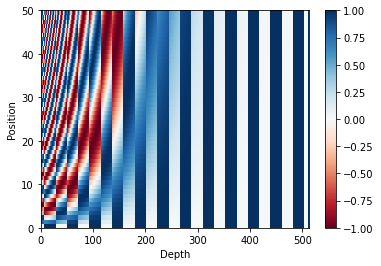

In [20]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # (batch size, sent_len, n_heads, depth). depth =d_model / d_heads
        # (20,25,8,64)
        return tf.transpose(x, perm=[0, 2, 1, 3]) # x값 위치 바꿈
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weight = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # 바꾼 x값 위치 원위치

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        
        # output = 어텐션 행렬
        return output, attention_weight

In [23]:
# Feed-Forward
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(kargs['dff'], activation='relu'),
                                tf.keras.layers.Dense(kargs['d_model'])
    ])

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        # Multi-Head Attention
        attn_output, _ = self.mha(x, x, x, mask) # k q v => x x x
        attn_output = self.dropout1(attn_output)
        
        # Add & Norm
        out1 = self.layernorm1(x + attn_output)

        # FeedForward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)

        # 전 output이랑 현재 나온 output이랑 더해서 다음 layer로 들어감 (2번째 add & norm)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate']) # 일반화 (Generalization)
    
    def call(self, x, mask):
    # x = index_input
      seq_len = tf.shape(x)[1] # 문장 길이

      x = self.embedding(x) # input_embedding
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :] # positional encoding

      x = self.dropout(x)

      for i in range(self.num_layers):
          x = self.enc_layers[i](x, mask) # encoding layer의 input

      return x

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # Masked Multi-Head Attention
        attn1, attn_weight_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        # Add & Norm
        out1 = self.layernorm1(attn1 + x)

        # Multi-Head Attention
        attn2, attn_weight_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) # v k q
        attn2 = self.dropout2(attn2)
        # Add & Norm
        out2 = self.layernorm2(attn2 + x)

        # Feed-Forward
        ffn_output= self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        #Add & Norm
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weight_block1, attn_weight_block2

In [34]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['output_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]

        self.drop_out = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weight = {}

        x = self.embedding(x) # output embedding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.drop_out(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
            attention_weight['decoder_layers{}_block1'.format(i + 1)] = block1
            attention_weight['decoder_layers{}_block2'.format(i + 1)] = block2

        return x, attention_weight

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])

        self.end_token_idx = kargs['end_token_idx']

        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['output_vocab_size'])

    def call(self, x):
        input, output = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
        enc_output = self.encoder(input, enc_padding_mask)

        dec_output, _  = self.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output

    def inference(self, x):
        input = x
        output = tf.expand_dim([SOS_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
        enc_output= self.encoder(input, enc_padding_mask)

        predict_tokens = []
        for t in range(MAX_SEQUENCE):
            dec_output, _ = self.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            
            predict_tokens.append(pred_token)
            output = tf.expand_dims([SOS_INDEX] + predict_tokens) 
            _, look_ahead_mask, _ = create_masks(input, output)

        return predict_tokens

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [30]:
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [36]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

In [32]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True)

In [37]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCH, 
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
444/444 [==============================] - 87s 172ms/step - loss: 1.5211 - accuracy: 0.7947 - val_loss: 1.5707 - val_accuracy: 0.7996

Epoch 00001: val_accuracy improved from -inf to 0.79960, saving model to /content/drive/MyDrive/Colab Notebooks/NLP/modelstransformer_kor/weights.h5
Epoch 2/30
444/444 [==============================] - 75s 168ms/step - loss: 1.1972 - accuracy: 0.8058 - val_loss: 1.4844 - val_accuracy: 0.8104

Epoch 00002: val_accuracy improved from 0.79960 to 0.81045, saving model to /content/drive/MyDrive/Colab Notebooks/NLP/modelstransformer_kor/weights.h5
Epoch 3/30
444/444 [==============================] - 74s 168ms/step - loss: 1.0457 - accuracy: 0.8148 - val_loss: 1.4555 - val_accuracy: 0.8180

Epoch 00003: val_accuracy improved from 0.81045 to 0.81805, saving model to /content/drive/MyDrive/Colab Notebooks/NLP/modelstransformer_kor/weights.h5
Epoch 4/30
444/444 [==============================] - 74s 166ms/step - loss: 0.9262 - accuracy: 0.8216 - val_

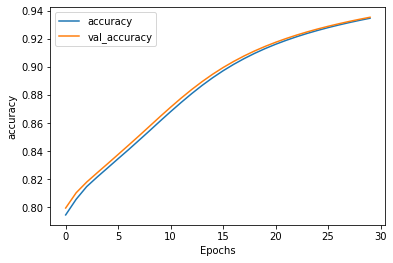

In [38]:
plot_graphs(history, 'accuracy')

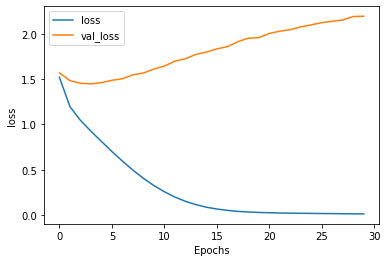

In [39]:
plot_graphs(history, 'loss')

In [44]:
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, 'weights.h5'))

In [45]:
word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']

In [46]:
def inference(model, x):
    input = x
    output = tf.expand_dims([SOS_INDEX], 0)

    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(input, output)
    enc_output= model.encoder(input, enc_padding_mask)

    predict_tokens = []
    for t in range(MAX_SEQUENCE):
        dec_output, _ = model.decoder(output, enc_output, look_ahead_mask, dec_padding_mask)
        final_output = model.final_layer(dec_output)
        outputs = tf.argmax(final_output, -1).numpy()
        pred_token = outputs[0][-1]
        if pred_token == model.end_token_idx:
            break
        
        predict_tokens.append(pred_token)
        output = tf.expand_dims([SOS_INDEX] + predict_tokens, 0) 
        _, look_ahead_mask, _ = create_masks(input, output)

    return predict_tokens

In [47]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], word2idx)
outputs = inference(model, test_index_inputs)

print(" ".join([idx2word[str(o)] for o in outputs]))

평소 에 필요했던 게 좋을 것 같아요
